In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import untils
from GMMDeepTaxonNet import GMMDeepTaxonNet
import argparse

from sklearn.mixture import GaussianMixture

import os
import sys

In [3]:
# load mnist
download = True
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# normalize
# mnist_transform.append(transforms.Normalize((0.1307,), (0.3081,)))
# mnist_transform.append(transforms.Normalize((0.1307,), (0.3081,)))

dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [5]:
def t_sne(model, test_loader, device, epoch):
    all_latent = []
    all_labels = []
    for i, (data, target) in enumerate(test_loader):
        with torch.no_grad():
            data = data.view(-1, 28*28).to(device)
            mu, logvar = model.encode(data)
            latent = model.reparameterize(mu, logvar)
            all_latent.append(latent)
            all_labels.append(target)
            if i == 2:
                break

    all_latent = torch.cat(all_latent, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_latent = all_latent.cpu().numpy()
    all_labels = all_labels.cpu().numpy()
    
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(all_latent)
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_labels, cmap='tab10', s=10)
    plt.colorbar()
    # plt.savefig(f'viz_out/vade{epoch}.png')
    plt.savefig(f'viz_out/vade_tree_{epoch}.png')

    plt.close()


In [ ]:
n_layers=4
model = GMMDeepTaxonNet(n_layers=n_layers, 
                        encoder_shared=True
                        ).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# train 
epochs = 500
for epoch in range(epochs):
    model.train()
    if epoch % 10 == 0:
        t_sne(model, mnist_test_loader, device, epoch)
    for i, (data, _) in enumerate(mnist_train_loader):
        data = data.view(-1, 28*28).to(device)
        #---------ELBO loss------------#
        optimizer.zero_grad()
        loss, recloss, kl1, kl2 = model(data)
        # print('loss:', loss.item(), 'recloss:', recloss.item(), 'kl1:', kl1.item(), 'kl2:', kl2.item())
        # break
        # print('kl1:', kl1.item(), 'kl2:', kl2.item())
        #----------------------------#
        loss.backward()
        optimizer.step()
        # if i % 100 == 0:
    print('Epoch:', epoch, 'Loss:', loss.item())

In [66]:
t_sne(model, mnist_test_loader, device, epoch, n_layers=n_layers)

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [73]:
# save model
torch.save(model.state_dict(), 'vade_tree.pth')

In [6]:
# load model
n_layers=4
model = GMMDeepTaxonNet(n_layers=n_layers, 
                        encoder_shared=True
                        ).to(device)
model.load_state_dict(torch.load('vade_tree.pth'))

<All keys matched successfully>

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(31, 32)


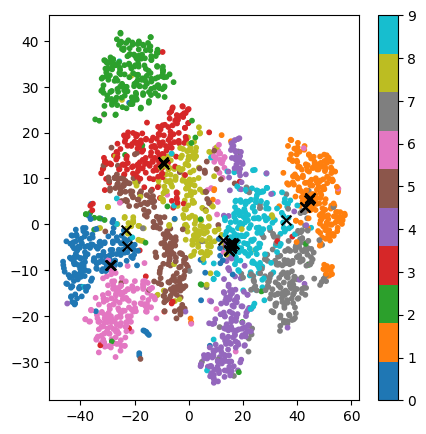

In [23]:
# plot datapoints along with the centroids
all_latent = []
all_labels = []
mu_c = None

with torch.no_grad():
    for i, (data, target) in enumerate(mnist_test_loader):
        data = data.view(-1, 28*28).to(device)
        mu, logvar = model.encode(data)
        latent = model.reparameterize(mu, logvar)
        all_latent.append(latent)
        all_labels.append(target)
        if i == 1:
            break
    mu_c = model.gmm_params()[1].detach().cpu().numpy()
    # mu_c = mu_c[-5:]
    print(mu_c.shape)


all_latent = torch.cat(all_latent, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_latent = all_latent.cpu().numpy()
# concate with mu_c
all_latent = np.concatenate((all_latent, mu_c), axis=0)


all_labels = all_labels.cpu().numpy()

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(all_latent)
plt.figure(figsize=(5, 5))
plt.scatter(tsne_results[:len(all_labels), 0], tsne_results[:len(all_labels), 1], c=all_labels, cmap='tab10', s=10)
plt.colorbar()
plt.scatter(tsne_results[len(all_labels):, 0], tsne_results[len(all_labels):, 1], c='black', s=50, marker='x')


In [30]:
with torch.no_grad():
    for i, (data, target) in enumerate(mnist_test_loader):
        data = data.view(-1, 28*28).to(device)
        # forward pass
        model(data)
        if i == 0:
            break

tensor([30, 30, 30, 30, 18, 30, 30, 30, 26, 25, 30, 18, 30, 30, 30, 30, 19, 30,
        19, 30, 26, 30, 30, 30, 30, 18, 30, 30, 19, 28, 26, 26, 30, 25, 25, 30,
        30, 30, 30, 30, 26, 30, 30, 24, 30, 19, 30, 30, 26, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 29, 30, 30, 30, 30, 30, 19, 18, 18, 30,
        25, 29, 30, 26, 26, 26, 30, 25, 30, 19,  4, 30, 29, 28, 30, 30, 19, 30,
        30, 28, 29, 30, 30, 30, 19, 30, 26, 30], device='cuda:0')


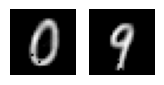

In [33]:
# decode the centroids
at_layer = 2 # root layer
if at_layer == 1:
    centroids = model.gmm_params()[1][-(2**(at_layer)-1):]
else:
    centroids = model.gmm_params()[1][-(2**(at_layer)-1):-(2**(at_layer-1)-1)]

# centroids = torch.zeros(1, 32).to(device)
centroids = model.decode(centroids)
centroids = centroids.view(-1, 28, 28).detach().cpu().numpy()
# plot 8 * 8 centroids 
plt.figure(figsize=(8, 8))
for i in range(len(centroids)):
    plt.subplot(8, 8, i+1)
    plt.imshow(centroids[i], cmap='gray')
    plt.axis('off')
# plt.savefig('viz_out/centroids.png')
plt.show()

In [22]:
# print gaussian p(c) at each layer
pi = model.gmm_params()[0].detach().cpu().numpy()
# print('pi:', pi)
# print pi
n_layers = model.n_layers
for i in range(0, n_layers):
    if i == 0:
        print('Layer:', i, 'p(c):', pi[-(2**(i+1)-1):])
    else:
        print('Layer:', i, 'p(c):', pi[-(2**(i+1)-1):-(2**i-1)])

Layer: 0 p(c): [0.19999999]
Layer: 1 p(c): [0.1266748  0.07332517]
Layer: 2 p(c): [0.04279482 0.08387999 0.03244473 0.04088045]
Layer: 3 p(c): [0.01144444 0.03135038 0.03552968 0.04835032 0.00102461 0.03142012
 0.00823006 0.03265039]


In [8]:
import torch
import matplotlib.pyplot as plt

def sample_from_learned_gaussian(model, device, grid_size=8):
    """
    Samples images from the learned Gaussian prior of a VaDE model (with a single Gaussian)
    and displays them in an 8x8 grid.
    
    Parameters:
        model: The trained VaDE model with a .gmm_params() method and a decoder.
        device: The device (e.g., torch.device("cuda") or torch.device("cpu")).
        grid_size: Number of rows/columns in the grid (default is 8 for an 8x8 grid).
    """
    model.eval()  # Set the model to evaluation mode
    num_samples = grid_size * grid_size  # Total number of samples (e.g., 64 for an 8x8 grid)
    
    with torch.no_grad():
        # Retrieve the learned GMM parameters (for a single Gaussian)
        pi, learned_mu, learned_logvar = model.gmm_params()
        
        # Ensure the parameters have a batch dimension.
        # If they are 1D tensors (shape [latent_dim]), unsqueeze to shape [1, latent_dim]
        if learned_mu.dim() == 1:
            learned_mu = learned_mu.unsqueeze(0)
            learned_logvar = learned_logvar.unsqueeze(0)
        
        latent_dim = learned_mu.size(1)
        # Expand the learned parameters to sample the desired number of points
        mu_expanded = learned_mu.expand(num_samples, latent_dim)
        logvar_expanded = learned_logvar.expand(num_samples, latent_dim)
        
        # Reparameterization trick using the learned mean and variance
        std = torch.exp(0.5 * logvar_expanded)
        eps = torch.randn(num_samples, latent_dim).to(device)
        z = mu_expanded + eps * std
        
        # Generate images by passing the latent samples through the decoder
        samples = model.decoder(z)
        # Reshape to image format (e.g., for MNIST: 1x28x28)
        samples = samples.view(-1, 1, 28, 28)
    
    # Plot the generated samples using an 8x8 grid of subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size, grid_size))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].cpu().numpy().squeeze(), cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'model' is your trained VaDE model and 'device' is properly set.
sample_from_learned_gaussian(model, device)


RuntimeError: The expanded size of the tensor (64) must match the existing size (31) at non-singleton dimension 0.  Target sizes: [64, 32].  Tensor sizes: [31, 32]